In [14]:
%load_ext autoreload
%autoreload 2

## 01 - Exploratory Data Analysis - Initial EDA 

(Python + tsforge)

**Goal** Get a fast, working understanding of our dataset *as a forecasting panel*, prove it’s modeling-ready, and produce a simple baseline forecast. We’ll keep it practical and direct:
- Load the prepared train/test splits (full + subset) from the setup.
- Run focused EDA for time series (frequency, completeness, zeros, outliers).
- Summarize/Pad/Visualize with `tsforge` wrappers (over Nixtla + pytimetk).


> We’re not polishing models here. We’re checking **data completeness**, **readiness**, and **signal health** 



In [1]:
import pandas as pd
import numpy as np

from tsforge.eda import *
from tsforge.feature_engineering import *

### 1. Business Understanding & Data Terminology  

The M5 dataset comes from Walmart’s daily sales records across the U.S., and it’s structured to reflect the way a real retailer manages its business. Each row of sales data links to a specific **item** (SKU) sold in a particular **store** within a given **state**. Items are grouped into **departments** and **categories**, which gives us a product hierarchy, while stores roll up to regions (states). Alongside sales, we also have **calendar data** (dates, events, SNAP/holiday flags) and **price data** (weekly store–item prices).  Understanding these dimensions—product, location, time, and price—is critical because they mirror the decisions a business actually makes: What to sell, where to sell it, when demand shifts, and at what price. This shared terminology will frame the rest of our exploration and modeling.

**What we’re trying to achieve**
- Translate dataset fields into *forecasting words* so the team speaks the same language.

**Key terms we’ll use consistently**
- **Series ID (`unique_id`)**: one item × one store (our basic unit to forecast).
- **Date (`date`)**: timestamp of the observation.
- **Target (`sales`)**: what we predict.
- **Hierarchy**: Location: `state_id → store_id` Product: `cat_id → dept_id → item_id).
- **Exogenous (X)**: `calendar` (events/holidays/SNAP), `prices` (weekly sell_price). 
- **Horizon**: 28 days (M5 standard).
- **Grain**: daily (we’ll also summarize to weekly/monthly for diagnostics).




### 2 - View Dataset 

In [2]:
train_df = pd.read_parquet('../data/input/processed/00_m5_sales_train.parquet')
train_df.head()

item_id  dept_id cat_id store_id state_id       date  sales  \
0  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-01-29    3.0   
1  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-02-01    1.0   
2  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-02-02    4.0   
3  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-02-03    2.0   
4  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-02-05    2.0   

          unique_id  
0  FOODS_1_001_CA_1  
1  FOODS_1_001_CA_1  
2  FOODS_1_001_CA_1  
3  FOODS_1_001_CA_1  
4  FOODS_1_001_CA_1

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4959320 entries, 0 to 4959319
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   item_id    object        
 1   dept_id    object        
 2   cat_id     object        
 3   store_id   object        
 4   state_id   object        
 5   date       datetime64[ns]
 6   sales      float32       
 7   unique_id  object        
dtypes: datetime64[ns](1), float32(1), object(6)
memory usage: 283.8+ MB


In [3]:
calendar_df = pd.read_parquet('../data/input/processed/00_m5_calendar.parquet')
calendar_df.head()

date event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  \
0 2011-01-29          nan          nan          nan          nan        0   
1 2011-01-30          nan          nan          nan          nan        0   
2 2011-01-31          nan          nan          nan          nan        0   
3 2011-02-01          nan          nan          nan          nan        1   
4 2011-02-02          nan          nan          nan          nan        1   

   snap_TX  snap_WI  
0        0        0  
1        0        0  
2        0        0  
3        1        0  
4        0        1

SNAP = Supplemental Nutrition Assistance Program (formerly called food stamps). They are benefit payout days, not holidays.

In [14]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   event_name_1  1969 non-null   category      
 2   event_type_1  1969 non-null   category      
 3   event_name_2  1969 non-null   category      
 4   event_type_2  1969 non-null   category      
 5   snap_CA       1969 non-null   uint8         
 6   snap_TX       1969 non-null   uint8         
 7   snap_WI       1969 non-null   uint8         
dtypes: category(4), datetime64[ns](1), uint8(3)
memory usage: 30.8 KB


In [4]:
calendar_df[['event_name_1', 'event_type_1']].dropna().drop_duplicates()

event_name_1 event_type_1
0                    nan          nan
8              SuperBowl     Sporting
16         ValentinesDay     Cultural
23         PresidentsDay     National
39             LentStart    Religious
46             LentWeek2    Religious
47         StPatricksDay     Cultural
50             Purim End    Religious
85        OrthodoxEaster    Religious
87            Pesach End    Religious
96         Cinco De Mayo     Cultural
99          Mother's day     Cultural
121          MemorialDay     National
122       NBAFinalsStart     Sporting
134         NBAFinalsEnd     Sporting
141         Father's day     Cultural
156      IndependenceDay     National
184       Ramadan starts    Religious
214          Eid al-Fitr    Religious
219             LaborDay     National
254          ColumbusDay     National
275            Halloween     Cultural
282            EidAlAdha    Religious
286          VeteransDay     National
299         Thanksgiving     National
330            Christmas     National
333         Chanukah End    Religious
337              NewYear     National
343    OrthodoxChristmas    Religious
352  MartinLutherKingDay     National
435               Easter     Cultural

In [5]:
prices_df = pd.read_parquet('../data/input/processed/00_m5_prices_subset.parquet')

prices_df.head()

item_id store_id       date  price         unique_id
0  FOODS_1_001     CA_1 2011-01-29    2.0  FOODS_1_001_CA_1
1  FOODS_1_001     CA_1 2011-01-30    2.0  FOODS_1_001_CA_1
2  FOODS_1_001     CA_1 2011-01-31    2.0  FOODS_1_001_CA_1
3  FOODS_1_001     CA_1 2011-02-01    2.0  FOODS_1_001_CA_1
4  FOODS_1_001     CA_1 2011-02-02    2.0  FOODS_1_001_CA_1

In [20]:
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11476249 entries, 0 to 47640136
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   item_id    object        
 1   store_id   object        
 2   date       datetime64[ns]
 3   price      float32       
 4   unique_id  object        
dtypes: datetime64[ns](1), float32(1), object(3)
memory usage: 481.6+ MB


### 3 - Summarize By Time

Before diving deep into patterns, it’s often useful to **summarize sales at different time grains**. For example, we might look at raw daily records as-is, or aggregate them up to weekly totals for a smoother signal. This same approach is handy when your source data contains multiple observations per day (e.g., transactions or receipts) but your forecasting horizon is daily — in that case, aggregation ensures each day has a single clean demand value. We’ll start by showing a simple example without `groupby`, then move on to the more flexible `df.groupby` method for daily (`D`) and weekly (`W`) roll-ups.


In [ ]:
import tsforge as tsf
summarize_by_time(
    train_df,
    date_col="date",
    value_col="sales",
    freq="D",
    agg_func=["count","mean","sum","min","max","median", ("q75", lambda x: x.quantile(0.75))]
).head(2)

In [ ]:
import tsforge as tsf   
summarize_by_time(
    train_df.groupby('unique_id'),
    date_col="date",
    value_col="sales",
    freq="D",
    agg_func=["count","mean","sum","min","max","median"],
    engine = 'pandas'
).head(2)

ModuleNotFoundError: No module named 'tsforge.plots'

In [34]:
train_df[(train_df.unique_id=='FOODS_1_001_CA_1') & (train_df.date=='2011-01-29')]

item_id  dept_id cat_id store_id state_id       date  sales  \
0  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-01-29    3.0   

          unique_id  
0  FOODS_1_001_CA_1

In [35]:
# Be careful with polars, there appears to be a bug with the count as i am getting different results with pandas vs polars
summarize_by_time(
    train_df.groupby('unique_id'),
    date_col="date",
    value_col="sales",
    freq="D",
    agg_func=["count","mean","sum","min","max","median"],
    engine = 'polars'
).head(2)

unique_id       date  sales_count  sales_mean  sales_sum  sales_min  \
0  FOODS_1_001_CA_1 2011-01-29          3.0         3.0        3.0        3.0   
1  FOODS_1_001_CA_1 2011-02-01          1.0         1.0        1.0        1.0   

   sales_max  sales_median  
0        3.0           3.0  
1        1.0           1.0

In [39]:
# very slow with pandas
summarize_by_time(
    train_df.groupby('unique_id'),
    date_col="date",
    value_col="sales",
    freq="W",
    agg_func=["count","mean","sum"],
    engine = 'pandas'
).head(2)

unique_id       date  sales_count  sales_mean  sales_sum
0  FOODS_1_001_CA_1 2011-01-30            1        3.00        3.0
1  FOODS_1_001_CA_1 2011-02-06            4        2.25        9.0

### 3. Time Series Summary Diagnostics  

Once we’ve aggregated our data to the right time grain, it’s helpful to generate a quick diagnostic report. The `summary_diagnostics` function from `tsf` provides an at-a-glance view of each series: start and end dates, length of history, % of missing values, zero counts, and basic statistics. This makes it easy to spot data quality issues early (like short series, sparse demand, or excessive zeros) before moving further into modeling.

The `summary_diagnostics` function has a parameter called `full_features`.  
By default it’s set to `True`, which means you’ll get the **complete set of diagnostics**, including:

- **Trend strength**: how much of the series is explained by a simple linear trend.  
- **Stationarity test (ADF p-value)**: a statistical test to check whether differencing is needed.  

These features can be **slow to compute**, especially on large panels, because they run regressions and statistical tests for each series.

In [7]:
summary_diagnostics(train_df, id_col="unique_id", date_col="date", value_col="sales", freq="D", full_features=False)

unique_id start_date   end_date  n_obs  n_expected  \
0         FOODS_1_001_CA_1 2011-01-29 2016-05-19    846        1938   
1         FOODS_1_001_CA_2 2011-01-29 2016-05-21   1000        1940   
2         FOODS_1_001_TX_1 2011-01-30 2016-05-22    642        1940   
3         FOODS_1_002_CA_1 2011-01-30 2016-05-22    650        1940   
4         FOODS_1_002_CA_2 2011-01-29 2016-05-22    719        1941   
...                    ...        ...        ...    ...         ...   
7447  HOUSEHOLD_2_515_CA_2 2014-01-18 2016-05-21    152         855   
7448  HOUSEHOLD_2_515_TX_1 2013-12-30 2016-01-03     91         735   
7449  HOUSEHOLD_2_516_CA_1 2011-01-30 2016-05-20    287        1938   
7450  HOUSEHOLD_2_516_CA_2 2011-02-05 2016-05-21    329        1933   
7451  HOUSEHOLD_2_516_TX_1 2011-02-13 2016-04-14    214        1888   

      n_missing  pct_missing  avg_interval  min_interval  max_interval  ...  \
0          1092    56.346749      2.292308             1            99  ...   
1           940    48.453608      1.940941             1            94  ...   
2          1298    66.907216      3.024961             1            94  ...   
3          1290    66.494845      2.987673             1           313  ...   
4          1222    62.957239      2.701950             1           326  ...   
...         ...          ...           ...           ...           ...  ...   
7447        703    82.222222      5.655629             1            48  ...   
7448        644    87.619048      8.155556             1           132  ...   
7449       1651    85.190918      6.772727             1            91  ...   
7450       1604    82.979824      5.890244             1            98  ...   
7451       1674    88.665254      8.859155             1           155  ...   

      cv_value  skewness   kurtosis  n_zeros  pct_zeros  max_zero_run  \
0     0.744875  3.535708  20.978348        0        0.0             0   
1     0.845307  2.885462  12.031761        0        0.0             0   
2     0.992614  5.452564  47.791977        0        0.0             0   
3     0.519693  2.493567  10.988763        0        0.0             0   
4     0.614168  2.228535   6.895338        0        0.0             0   
...        ...       ...        ...      ...        ...           ...   
7447  0.414647  1.920190   2.806513        0        0.0             0   
7448  0.418507  2.912049  10.142729        0        0.0             0   
7449  0.334251  3.305972  10.868505        0        0.0             0   
7450  0.402365  3.092747  13.626041        0        0.0             0   
7451  0.286065  3.897414  15.769201        0        0.0             0   

      n_outliers  pct_outliers  trend_strength  adf_pval  
0             20      2.364066             NaN       NaN  
1             28      2.800000             NaN       NaN  
2             10      1.557632             NaN       NaN  
3             15      2.307692             NaN       NaN  
4             15      2.086231             NaN       NaN  
...          ...           ...             ...       ...  
7447           6      3.947368             NaN       NaN  
7448           2      2.197802             NaN       NaN  
7449           5      1.742160             NaN       NaN  
7450           7      2.127660             NaN       NaN  
7451           2      0.934579             NaN       NaN  

[7452 rows x 26 columns]

### 4. Padding Missing Dates with `fill_missing`

From our diagnostics we saw that some series had gaps — days where no row exists in the data.  
Before we can model, we need to make sure **every series has a complete calendar**: one row per date per ID.  

Nixtla provides a fast utility called [`fill_missing`](https://nixtla.github.io/statsforecast/utils.html#fill_missing) that does exactly this.  
It expands each time series to a full sequence of dates (based on the chosen frequency) and fills missing values with your choice of strategy — for example:
- `fill_value=0` for demand (so a missing row becomes zero sales),  
- `fill_value=None` + `ffill=True` if you want to forward-fill things like prices.  

This step ensures that all series are aligned and consistent, which is essential for rolling up, reconciling, or passing data into forecasting models.


In [7]:
print(train_df.shape)
from utilsforecast.preprocessing import fill_gaps

# Example: ensure continuous daily dates per series
sales_filled = fill_gaps(
    df=train_df,
    freq='D',
    id_col='unique_id',
    time_col='date',
)

print(sales_filled.shape)
sales_filled.head()

(4959320, 8)
(11267593, 8)


unique_id       date      item_id  dept_id cat_id store_id state_id  \
0  FOODS_1_001_CA_1 2011-01-29  FOODS_1_001  FOODS_1  FOODS     CA_1       CA   
1  FOODS_1_001_CA_1 2011-01-30          NaN      NaN    NaN      NaN      NaN   
2  FOODS_1_001_CA_1 2011-01-31          NaN      NaN    NaN      NaN      NaN   
3  FOODS_1_001_CA_1 2011-02-01  FOODS_1_001  FOODS_1  FOODS     CA_1       CA   
4  FOODS_1_001_CA_1 2011-02-02  FOODS_1_001  FOODS_1  FOODS     CA_1       CA   

   sales  
0    3.0  
1    NaN  
2    NaN  
3    1.0  
4    4.0

In [46]:
help(fill_gaps)

Help on function fill_gaps in module utilsforecast.preprocessing:

fill_gaps(df: ~DFType, freq: Union[str, int], start: Union[str, int, datetime.date, datetime.datetime] = 'per_serie', end: Union[str, int, datetime.date, datetime.datetime] = 'global', id_col: str = 'unique_id', time_col: str = 'ds') -> ~DFType
    Enforce start and end datetimes for dataframe.

    Parameters
    ----------
    df : pandas or polars DataFrame
        Input data
    freq : str or int
        Series' frequency
    start : str, int, date or datetime.
        Initial timestamp for the series.
            * 'per_serie' uses each serie's first timestamp
            * 'global' uses the first timestamp seen in the data
            * Can also be a specific timestamp or integer, e.g. '2000-01-01', 2000 or datetime(2000, 1, 1)
    end : str, int, date or datetime.
        Initial timestamp for the series.
            * 'per_serie' uses each serie's last timestamp
            * 'global' uses the last timestamp see

Default behavior for start and end is the start will go per series and end will be global.  Typically this is the behavior you want.

### 5. Dealing with Missing Values  

Our diagnostics and padding steps showed that some values are missing.  
When cleaning time series, it’s important to treat **categorical columns** differently from the **value column (sales)**.

#### Categorical columns (item_id, dept_id, cat_id, store_id, state_id, …)
- These identifiers are **static metadata** — they don’t change over time.  
- If they are missing in the long time-series panel, that usually means the join didn’t propagate correctly.  
- **Best practice:**  
  - Keep a separate `meta_df` with one row per `unique_id` and all categorical descriptors.  
  - Drop them from the transactional panel and re-merge later if needed.  
  - This keeps the time-series table lean and avoids forward-filling values that never actually change.

#### Sales (value column)
- Missing values here are more serious: are they **true zeros** (no sales) or **gaps** (data not recorded)?  
- After `fill_gaps`, every date should be present for each ID. At that point:  
  - If a row is present but sales = NA → usually fill with **0** (most common assumption in retail).  
  - If business rules suggest otherwise (e.g. stockouts, data outages), consider flagging those days with a `was_missing=1` column for transparency.

#### Summary
- **Categoricals → re-merge from metadata.**  
- **Sales → fill with 0 (unless flagged otherwise).**


In [8]:
# Replace missing sales with 0 values
sales_filled['sales'] = sales_filled['sales'].fillna(0)

In [9]:
# Build a clean metadata table dynamically
print("Check start size:", sales_filled.shape)
meta_df = (
    sales_filled
    .drop(columns=['date', 'sales'], errors='ignore')  # keep only categoricals/IDs
    .dropna()
    .drop_duplicates()
)

ts_df = sales_filled[['unique_id', 'date', 'sales']]

train_df_full = pd.merge(ts_df, meta_df, on='unique_id', how='left')

print("Check end size:", train_df_full.shape)
train_df_full.head()


Check start size: (11267593, 8)
Check end size: (11267593, 8)


unique_id       date  sales      item_id  dept_id cat_id store_id  \
0  FOODS_1_001_CA_1 2011-01-29    3.0  FOODS_1_001  FOODS_1  FOODS     CA_1   
1  FOODS_1_001_CA_1 2011-01-30    0.0  FOODS_1_001  FOODS_1  FOODS     CA_1   
2  FOODS_1_001_CA_1 2011-01-31    0.0  FOODS_1_001  FOODS_1  FOODS     CA_1   
3  FOODS_1_001_CA_1 2011-02-01    1.0  FOODS_1_001  FOODS_1  FOODS     CA_1   
4  FOODS_1_001_CA_1 2011-02-02    4.0  FOODS_1_001  FOODS_1  FOODS     CA_1   

  state_id  
0       CA  
1       CA  
2       CA  
3       CA  
4       CA

In [12]:
summary_diagnostics(train_df_full, id_col="unique_id", date_col="date", value_col="sales", freq="D", full_features=False)

unique_id start_date   end_date  n_obs  n_expected  \
0         FOODS_1_001_CA_1 2011-01-29 2016-05-22   1941        1941   
1         FOODS_1_001_CA_2 2011-01-29 2016-05-22   1941        1941   
2         FOODS_1_001_TX_1 2011-01-30 2016-05-22   1940        1940   
3         FOODS_1_002_CA_1 2011-01-30 2016-05-22   1940        1940   
4         FOODS_1_002_CA_2 2011-01-29 2016-05-22   1941        1941   
...                    ...        ...        ...    ...         ...   
7447  HOUSEHOLD_2_515_CA_2 2014-01-18 2016-05-22    856         856   
7448  HOUSEHOLD_2_515_TX_1 2013-12-30 2016-05-22    875         875   
7449  HOUSEHOLD_2_516_CA_1 2011-01-30 2016-05-22   1940        1940   
7450  HOUSEHOLD_2_516_CA_2 2011-02-05 2016-05-22   1934        1934   
7451  HOUSEHOLD_2_516_TX_1 2011-02-13 2016-05-22   1926        1926   

      n_missing  pct_missing  avg_interval  min_interval  max_interval  ...  \
0             0          0.0           1.0             1             1  ...   
1             0          0.0           1.0             1             1  ...   
2             0          0.0           1.0             1             1  ...   
3             0          0.0           1.0             1             1  ...   
4             0          0.0           1.0             1             1  ...   
...         ...          ...           ...           ...           ...  ...   
7447          0          0.0           1.0             1             1  ...   
7448          0          0.0           1.0             1             1  ...   
7449          0          0.0           1.0             1             1  ...   
7450          0          0.0           1.0             1             1  ...   
7451          0          0.0           1.0             1             1  ...   

      cv_value  skewness   kurtosis  n_zeros  pct_zeros  max_zero_run  \
0     1.602225  3.162190  18.760923     1095  56.414219            98   
1     1.525694  2.934097  13.431265      941  48.480165            93   
2     2.235414  6.152783  70.293427     1298  66.907216            93   
3     1.670599  2.115652   6.847106     1290  66.494845           312   
4     1.648592  2.262233   7.094940     1222  62.957239           325   
...        ...       ...        ...      ...        ...           ...   
7447  2.366432  2.606717   7.107507      704  82.242991            47   
7448  3.208232  3.885025  19.092524      784  89.600000           140   
7449  2.552550  2.769731   8.691444     1653  85.206186            90   
7450  2.414590  2.824879  10.425472     1605  82.988625            97   
7451  2.955942  3.135955  10.939291     1712  88.888889           154   

      n_outliers  pct_outliers  trend_strength  adf_pval  
0             32      1.648635             NaN       NaN  
1             35      1.803194             NaN       NaN  
2             36      1.855670             NaN       NaN  
3             50      2.577320             NaN       NaN  
4             41      2.112313             NaN       NaN  
...          ...           ...             ...       ...  
7447          33      3.855140             NaN       NaN  
7448          16      1.828571             NaN       NaN  
7449          29      1.494845             NaN       NaN  
7450          56      2.895553             NaN       NaN  
7451          16      0.830737             NaN       NaN  

[7452 rows x 26 columns]

In practice, different columns may need different fill rules —
e.g., sales → 0, prices → forward-fill, weather → interpolate.
That’s why we separate meta and treat each variable deliberately.

### 6. Merging Calendar Features  

So far we’ve built a clean time series panel with one row per ID per date.  
The next step is to bring in **calendar features** such as events, SNAP program days, and holiday flags.  
These features provide important external signals that help models explain and predict demand spikes.  

In practice, this means joining our `train_df_full` (time series) with the `calendar_df` on the date column.  
After the merge, each row of our time series has the extra columns for events and SNAP indicators, ready for use in modeling.


In [65]:
print("Before merge:", train_df_full.shape)

# Merge calendar features
train_df_full_w_cal = (
    train_df_full
    .merge(calendar_df, on='date', how='left')
)

print("After merge:", train_df_full_w_cal.shape)
train_df_full_w_cal.head()

Before merge: (11267593, 8)
After merge: (11267593, 15)


unique_id       date  sales      item_id  dept_id cat_id store_id  \
0  FOODS_1_001_CA_1 2011-01-29    3.0  FOODS_1_001  FOODS_1  FOODS     CA_1   
1  FOODS_1_001_CA_1 2011-01-30    0.0  FOODS_1_001  FOODS_1  FOODS     CA_1   
2  FOODS_1_001_CA_1 2011-01-31    0.0  FOODS_1_001  FOODS_1  FOODS     CA_1   
3  FOODS_1_001_CA_1 2011-02-01    1.0  FOODS_1_001  FOODS_1  FOODS     CA_1   
4  FOODS_1_001_CA_1 2011-02-02    4.0  FOODS_1_001  FOODS_1  FOODS     CA_1   

  state_id event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  \
0       CA          nan          nan          nan          nan        0   
1       CA          nan          nan          nan          nan        0   
2       CA          nan          nan          nan          nan        0   
3       CA          nan          nan          nan          nan        1   
4       CA          nan          nan          nan          nan        1   

   snap_TX  snap_WI  
0        0        0  
1        0        0  
2        0        0  
3        1        0  
4        0        1

### 7. Visualizing the Time Series  

With a clean panel and calendar features merged in, the next step is to **visualize the data**.  
Plotting lets us quickly spot trends, seasonality, demand spikes, and the effect of events or SNAP days.  
Visual checks are often the fastest way to confirm whether our preprocessing has worked and whether the features look meaningful.  

In practice, we usually look at two kinds of plots:  
1. **Overlay plots** – multiple series on the same chart (good for comparing overall scale and shape).  
2. **Faceted plots** – one small chart per ID (good for seeing each series’ structure without overlap).  

We’ll use the `plot_series` helper from `tsforge` (which wraps Plotly/Matplotlib) to keep the code concise and interactive.


In [46]:
import importlib
import tsforge as tsf   # your package

importlib.reload(tsf)

<module 'tsforge' from 'C:\\Users\\tacke\\Documents\\GitHub\\tsforge\\src\\tsforge\\__init__.py'>

In [64]:
# Overlay a few series
fig = tsf.plot_series(
    train_df_full_w_cal,
    id_col='unique_id',
    date_col='date',
    value_col='sales',
    max_ids=6,
    engine='plotly',
    facet=True,
    facet_wrap = 3,
    smooth_window=28 
)
fig.show()


In [71]:
fig = tsf.plot_series(
    train_df_full_w_cal,
    id_col='unique_id',
    date_col='date',
    value_col='sales',
    max_ids=20,
    engine='plotly',
    facet=False,
    smooth_window=28,
    dropdown=True
)
fig.show()


In [72]:
fig = tsf.plot_series(
    train_df_full_w_cal,
    id_col='unique_id',
    date_col='date',
    value_col=lambda d: np.log1p(d["sales"]),
    max_ids=20,
    engine='plotly',
    facet=False,
    smooth_window=28,
    dropdown=True
)
fig.show()


In [76]:
fig = tsf.plot_series(
    train_df_full_w_cal,
    id_col="unique_id",
    date_col="date",
    value_col="sales",
    max_ids=3,
    engine="plotly",
    facet=True,
    smooth_window=28,
    freq="M"       # 👈 resample to weekly totals
)
fig.show()


### 8 Distribution of Sales

Before modeling, it’s important to see how demand is distributed.  
- Most SKUs sell **0–5 units on a typical day**.  
- A few days have large spikes (promotions or holidays).  
- This skewed, zero-inflated distribution is common in retail.  
- Visualizing both raw and log-transformed distributions highlights these patterns.

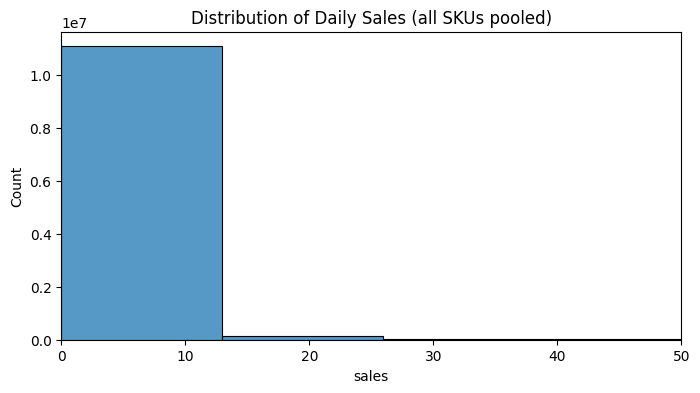

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.histplot(train_df_full_w_cal['sales'], bins=50, kde=False)
plt.xlim(0, 50)   # cap to focus on the body (filter out extreme spikes)
plt.title("Distribution of Daily Sales (all SKUs pooled)")
plt.show()

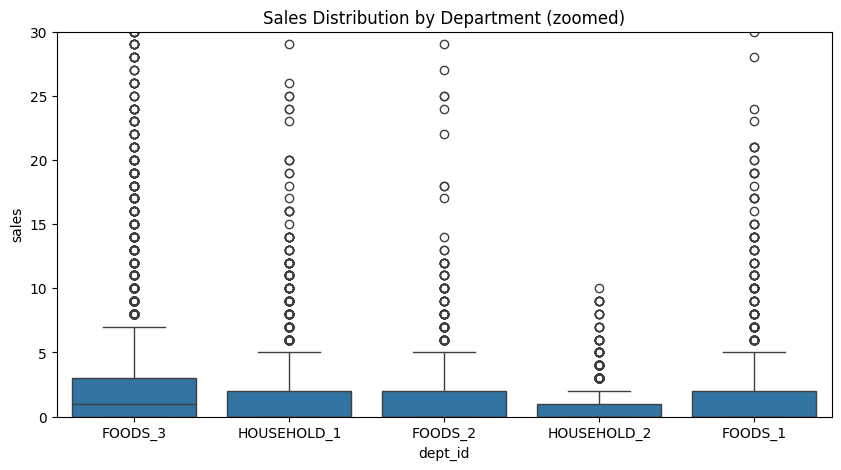

In [68]:
sample_df = train_df_full_w_cal.sample(20000, random_state=42)  # downsample for speed

plt.figure(figsize=(10,5))
sns.boxplot(x='dept_id', y='sales', data=sample_df)
plt.ylim(0, 30)  # zoom in
plt.title("Sales Distribution by Department (zoomed)")
plt.show()


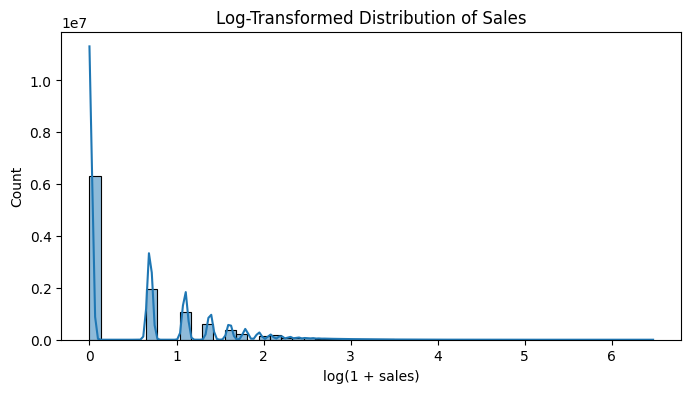

In [69]:
import numpy as np

plt.figure(figsize=(8,4))
sns.histplot(np.log1p(train_df_full['sales']), bins=50, kde=True)
plt.title("Log-Transformed Distribution of Sales")
plt.xlabel("log(1 + sales)")
plt.show()
